# Superposition by embedding bottleneck

This is an experiment to squash higher-dimensional data into a lower-dimensional embedding space. We'll start with color: RGB values (3 dimensions) ranging from 0..1. If we compress them into a 2D embedding, we should expect to see superposition, with directions interpretable as they would be in a classic color wheel: three primary color directions (RGB) spaced 120° apart.


## Training data

While we describe colors in terms of hue (the color wheel), saturation (color intensity), and value (brightness), RGB values combine these properties in a non-intuitive way. Since we aim to test whether hues naturally embed as a color wheel, our training data should use a color space that has hue as an axis — that way, we can create a train/test split that excludes certain hues. See the notebook [Training data: color](ex-color-data.ipynb) for an exploration of color cubes in this context.


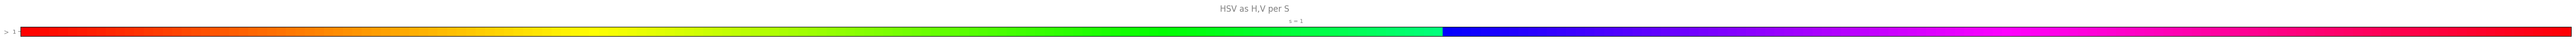

In [109]:
import numpy as np
from ex_color.data import ColorCube, hue_arange, hues, isbetween_cyclic
from ex_color.vis import plot_colors

all_hues = hue_arange(step_size=1 / 360)

cube = ColorCube.from_hsv(
    h=all_hues[~isbetween_cyclic(all_hues, hues.teal, hues.blue)],
    s=np.array([1]),
    v=np.array([1]),
)
plot_colors(cube.permute('svh'))

## Simple MLP with bottleneck

We'll train a simple 2-layer MLP with 2-dimensional bottleneck to map RGB values (inputs like [1.0, 0.0, 0.0] for red) to RGB values. This would force colors into a 2D space where we expect to see the superposition effect.

In [113]:
import torch
import torch.nn as nn
import numpy as np


class ColorMLP(nn.Module):
    def __init__(self, normalize_bottleneck=False):
        super().__init__()
        # RGB input (3D) → hidden layer → 2D bottleneck → hidden layer → RGB output
        self.encoder = nn.Sequential(
            nn.Linear(3, 4),
            nn.ReLU(),
            nn.Linear(4, 2),  # Our critical 2D bottleneck!
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 3),
            nn.Sigmoid(),  # Keep RGB values in [0,1]
        )

        self.normalize = normalize_bottleneck

    def forward(self, x):
        # Get our bottleneck representation
        bottleneck = self.encoder(x)

        # Optionally normalize to unit vectors (like nGPT)
        if self.normalize:
            norm = torch.norm(bottleneck, dim=1, keepdim=True)
            bottleneck = bottleneck / (norm + 1e-8)  # Avoid division by zero

        # Decode back to RGB
        output = self.decoder(bottleneck)
        return output, bottleneck


def train_color_model(model, data: torch.Tensor, epochs=500):
    from torch import optim
    from tqdm import tqdm

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Store bottleneck values for visualization
    bottleneck_history = []

    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            pbar.update(1)
            optimizer.zero_grad()

            # Forward pass
            outputs, _latents = model(data)
            loss = criterion(outputs, data)  # Autoencoder loss

            # Backward pass
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.item())
            if epoch % 50 == 0:
                # Save named colors' bottleneck representation
                with torch.no_grad():
                    _, latents = model(data)
                    bottleneck_history.append(latents.clone())

    return bottleneck_history


model = ColorMLP(normalize_bottleneck=True)
train_data = torch.tensor(cube.rgb_grid.reshape(-1, 3), dtype=torch.float32)
history = train_color_model(model, train_data, epochs=500)

100%|██████████| 500/500 [00:00<00:00, 509.26it/s, loss=0.0369]


Quick check to see what's in the bottleneck and the training data tensors...

In [114]:
print(history[-1][:3])
print(train_data[:3])

tensor([[0.9586, 0.2848],
        [0.9640, 0.2660],
        [0.9690, 0.2469]])
tensor([[1.0000, 0.0000, 0.0000],
        [1.0000, 0.0167, 0.0000],
        [1.0000, 0.0333, 0.0000]])


## Visualizing the bottleneck

By forcing fully-saturated RGB values through a 2D bottleneck, we expect the model to rediscover the color wheel. Let's draw a scatter plot of the bottleneck and see what comes out!

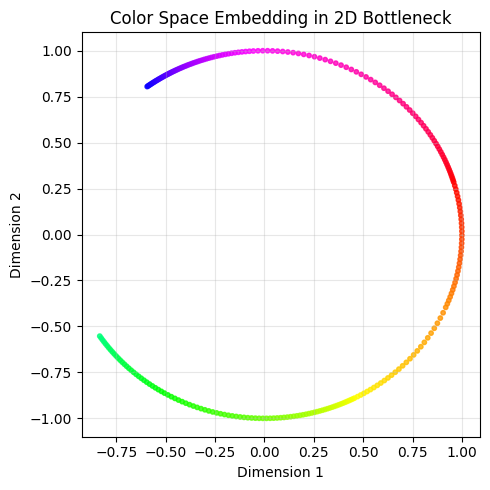

Bottleneck shape: (269, 2)
Range - X: [-0.8334, 1.0000]
Range - Y: [-1.0000, 1.0000]


In [115]:
import matplotlib.pyplot as plt

# Get the final bottleneck representations
final_bottleneck = history[-1]

# Convert tensors to numpy arrays for plotting
bottleneck_np = final_bottleneck.detach().numpy()
colors_np = train_data.numpy()

# Create a scatter plot with points colored by their RGB values
plt.figure(figsize=(5, 5))
plt.scatter(bottleneck_np[:, 0], bottleneck_np[:, 1], c=colors_np, s=10, alpha=0.8)

plt.title('Color Space Embedding in 2D Bottleneck')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Let's also analyze the shape of the distribution
print(f'Bottleneck shape: {bottleneck_np.shape}')
print(f'Range - X: [{bottleneck_np[:, 0].min():.4f}, {bottleneck_np[:, 0].max():.4f}]')
print(f'Range - Y: [{bottleneck_np[:, 1].min():.4f}, {bottleneck_np[:, 1].max():.4f}]')

Indeed, the model rediscovered the color wheel! Each time it's trained, the orientation changes — but the angles between the colours are consistent. Interestingly, there's a gap in the wheel where the held-out test data should fit, although we haven't actually checked to see what the model would do with it.

Although I expected this result, I'm not quite sure what it means. It could be interpreted in a couple of ways:

1. The 3D RGB triplets are forced into "superposition" in a 2D space, with the R, G and B axes no longer orthogonal.
2. The data were _really_ 1D all along (because only hue is varying), so embedding it in a 2D space should be trivial.

Still, this is a good start. Next I'd like to try some curriculum learning:
1. Train the model with fully-saturated hues, as above.
2. _Add_ a dimension to the bottleneck (but maintain existing weights), and continue training with more colors (varying in saturation or value).

Hopefully, we would see the positions of the hues held constant, with similar (new) colors placed nearby.